# Підключення основних бібліотек для роботи, завантаження данних, їх очистка та приведення до зручного для обробки вигляду.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import linregress
plt.style.use('seaborn')
%matplotlib inline

In [22]:
data = pd.read_excel('1.xlsx')
for i in range(105):
    data.Data.loc[i] = ''.join(list(data.Data.loc[i])[-10:])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [23]:
usd = pd.read_csv('USD.csv')
usd['Дата'] = pd.to_datetime(usd['Дата'])
usd = usd.drop(columns = ['Час', 'Код цифровий', 'Код літерний', 'Кількість одиниць'])
usd = usd[usd['Назва валюти'] == 'Долар США']
usd = usd.set_index(['Дата'])
usd = usd.loc['2017-01-03': '2018-12-31']
usd['Офіційний курс гривні, грн'] /= 100
usdm = usd.groupby(pd.Grouper(freq = '1W')).mean()
usdm.index = range(105)

In [24]:
zp = pd.read_excel('zp.xlsx', sheet_name = 1)
zp = zp.drop([0])
zp = zp[zp['attributes'] == 'У середньому по економіці']
zp = zp[8:16]
zp = zp.drop(columns = ['attributes', 'wages2', 'wages3'])

In [25]:
data.head()

,Data,Traffic,Brand Promo,Total Radio Competitors,OOH Total Comp,Киевская,Львовская,Харьковская,Tr,Rekl
0,03.01.2017,354200,0,177.336923,20.733836,39025.0,7591.0,56279.0,331159.0,0.0
1,10.01.2017,216926,0,171.023077,48.378950,23220.0,5987.0,34753.0,324568.0,0.0
2,17.01.2017,229382,0,116.202308,48.378950,27272.0,7595.0,37359.0,340623.0,0.0
3,24.01.2017,213922,0,138.172308,48.378950,25692.0,6762.0,34422.0,327606.0,345.0
4,31.01.2017,235057,345,318.702308,48.378950,26673.0,7836.0,37019.0,378418.0,765.0


# Побудова графіків для візуального аналізу данних та пошуку сезонних коливань

([<matplotlib.axis.XTick at 0x1bb8a1c8e80>,
 [Text(0, 0, '03.01.2017'),
  Text(10, 0, '13.03.2017'),
  Text(20, 0, '22.05.2017'),
  Text(30, 0, '31.07.2017'),
  Text(40, 0, '09.10.2017'),
  Text(50, 0, '18.12.2017'),
  Text(60, 0, '26.02.2018'),
  Text(70, 0, '07.05.2018'),
  Text(80, 0, '16.07.2018'),
  Text(90, 0, '24.09.2018'),
  Text(100, 0, '03.12.2018')])

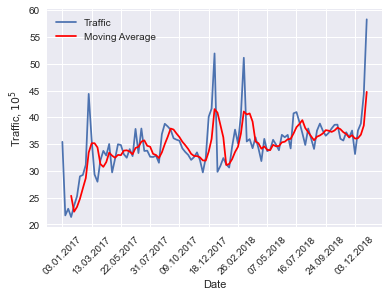

In [26]:
plt.plot(data.Data, data.Traffic / 10000, label = 'Traffic')
plt.plot(data.Data, data.Traffic.rolling(window=4).mean() / 10000, 'r', label = 'Moving Average')
plt.ylabel('Traffic, $10^5$')
plt.xlabel('Date')
plt.legend()
plt.xticks(range(len(data.Data))[::10],data.Data[::10], rotation = 45)
#plt.savefig('Traffic.png', dpi = 1000)

([<matplotlib.axis.XTick at 0x1bb8a142a90>,
 [Text(0, 0, '03.01.2017'),
  Text(10, 0, '13.03.2017'),
  Text(20, 0, '22.05.2017'),
  Text(30, 0, '31.07.2017'),
  Text(40, 0, '09.10.2017'),
  Text(50, 0, '18.12.2017'),
  Text(60, 0, '26.02.2018'),
  Text(70, 0, '07.05.2018'),
  Text(80, 0, '16.07.2018'),
  Text(90, 0, '24.09.2018'),
  Text(100, 0, '03.12.2018')])

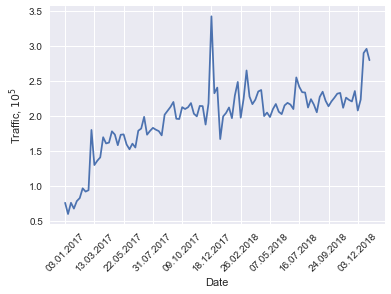

In [27]:
i = 'Львовская'
plt.plot(data.Data, data[i] / 10000)
plt.ylabel('Traffic, $10^5$')
plt.xlabel('Date')
plt.xticks(range(len(data.Data))[::10],data.Data[::10], rotation = 45)
#plt.savefig(i + '.png', dpi = 1000)

# Пошук статистичної залежності між швидкістю приросту трафіку в магазинах від кількості та місця розміщення реклами

In [28]:
data['T'] = (data['Traffic'].shift(3) +data['Traffic'].shift(2) + data['Traffic'].shift(1))/3   - data['Traffic']
data['R'] = (data['Total Radio Competitors'].shift(1)  - data['Total Radio Competitors'])
data['O'] = (data['OOH Total Comp'].shift(1)  - data['OOH Total Comp'])
data['USD'] = usdm
data['U'] = (data['USD'].shift(1)  - data['USD'])
data['S'] = data['O'] + data['R']
data['Data'] = pd.to_datetime(data['Data'])
#data = data.set_index(['Data'])



In [29]:
df = data.drop(columns = ['Киевская','Львовская','Харьковская'])
print(linregress(df['T'][3:104], df['O'][3:104]))

LinregressResult(slope=-0.00011877827319491583, intercept=-1.3388681150867985, rvalue=-0.2725397889317962, pvalue=0.005828102674444215, stderr=4.214342249179277e-05)


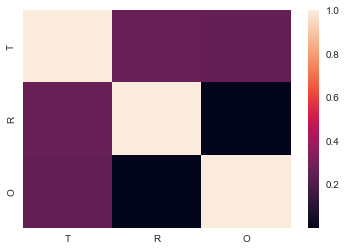

In [30]:
sns.heatmap(df[['T', 'R', 'O']].corr().apply(abs))
plt.savefig('TRO.png')

# Більш детальне дослідження однієї з рекламних кампаній

In [23]:
from scipy.stats import ttest_rel

In [24]:
Re = pd.read_excel('1.xlsx')[['Tr', 'Rekl']]

In [25]:
Re

,Tr,Rekl
0,331159.0,0.0
1,324568.0,0.0
2,340623.0,0.0
3,327606.0,345.0
4,378418.0,765.0
...,...,...
100,NaN,NaN
101,NaN,NaN
102,NaN,NaN
103,NaN,NaN


In [26]:
print(Re.Tr[2:5])
print(Re.Tr[5:8])

2    340623.0
3    327606.0
4    378418.0
Name: Tr, dtype: float64
5    333238.0
6    379098.0
7    337208.0
Name: Tr, dtype: float64


In [27]:
stat, p = ttest_rel(Re.Tr[0:4], Re.Tr[4:8])
print('p = %.3f' % (p))

p = 0.079


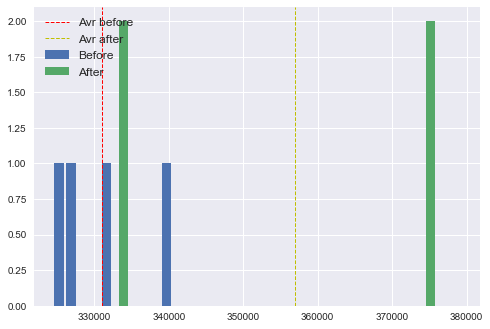

In [28]:
plt.hist(Re.Tr[0:4], width = 1300, label = 'Before')
plt.hist(Re.Tr[4:8], width = 1300, label = 'After')
plt.axvline(Re.Tr[0:4].mean(), color='r', linestyle='dashed', linewidth=1, label = 'Avr before')
plt.axvline(Re.Tr[4:8].mean(), color='y', linestyle='dashed', linewidth=1, label = 'Avr after')
plt.legend(loc = 'upper left', fontsize = 12)
plt.savefig('mid.png')